<a href="https://colab.research.google.com/github/eslamalaa10/fruits-360_dataset/blob/master/SVM_pattern_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**

In [0]:
# Import required libraries
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
ops.reset_default_graph()

TensorFlow 1.x selected.


In [0]:
!git clone https://github.com/eslamalaa10/fruits-360_dataset.git

import numpy as np
import os
from imutils import paths
import cv2
import pandas as pd
def load_images(path):
  print("[INFO] loading images...")
  imagePaths = list(paths.list_images(path))
  imagePaths.sort()
  data = []
  labels = []
  for imagePath in imagePaths:
    print(imagePath)
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (100, 100))
    data.append(image)
    labels.append(label)
  data = np.array(data)
  labels=pd.get_dummies(labels)
  labels = np.array(labels)
  return data,labels
x_test,y_test=load_images('/content/fruits-360_dataset/newtest')
x_train,y_train=load_images('/content/fruits-360_dataset/newtrain')

In [0]:
fruits=[]
imagePaths = list(paths.list_images('/content/fruits-360_dataset/newtest'))
imagePaths.sort()

for imagePath in imagePaths:
  fruits.append(imagePath.split(os.path.sep)[-2])
fruits = list(dict.fromkeys(fruits))
print(fruits)

['Apple Braeburn', 'Banana', 'Dates', 'Huckleberry']


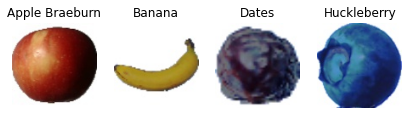

In [0]:
# Display samples of the dataset
fig, axes = plt.subplots(1, 4, figsize=(7, 3))

axes[0].set_title(fruits[(int(np.where( y_train[0] == 1)[0]))])
axes[0].imshow(x_train[0])
axes[0].axis('off')

axes[1].set_title(fruits[(int(np.where( y_train[600] == 1)[0]))])
axes[1].imshow(x_train[600])
axes[1].axis('off')

axes[2].set_title(fruits[(int(np.where( y_train[1200] == 1)[0]))])
axes[2].imshow(x_train[1200])
axes[2].axis('off')

axes[3].set_title(fruits[(int(np.where( y_train[1800] == 1)[0]))])
axes[3].imshow(x_train[1800])
axes[3].axis('off')
plt.show()

In [0]:
x_train.shape

(1962, 100, 100, 3)

In [0]:
# Normalize the dataset in the interval [0,1]
x_train = x_train.reshape(x_train.shape[0],100*100*3)/255.0
x_test = x_test.reshape(x_test.shape[0],100*100*3)/255.0

#### Model Structure
#### f(x,W,b)=Wx+B

In [0]:
# hyperparameters
learning_rate = 1.0
epochs = 100

batch_size = 100  
batches = int(x_train.shape[0] / batch_size) 

In [0]:
k=x_train.shape[1]

In [0]:
X = tf.placeholder(tf.float32, [None, k])
Y = tf.placeholder(tf.float32, [None, 4])

W = tf.Variable(tf.truncated_normal([k, 4]))
B = tf.Variable(tf.zeros(4))

In [0]:
model_output = tf.matmul(X, W) + B

Multiclass SVM loss function 


In [0]:
# Declare loss function
# L2 regularization

alpha = tf.constant([0.00001])
delta = tf.constant([0.01], tf.float32)

regulation_term = alpha * tf.nn.l2_loss(W) 

S_truelabel = tf.reduce_sum(tf.multiply(Y,model_output),axis=1 ,keepdims=True)
loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, model_output - S_truelabel + delta), 1) - delta )
loss += regulation_term

In [0]:
# Declare the optimizer for optimizing the loss function
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

test acc 93.35348
train acc 100.0 



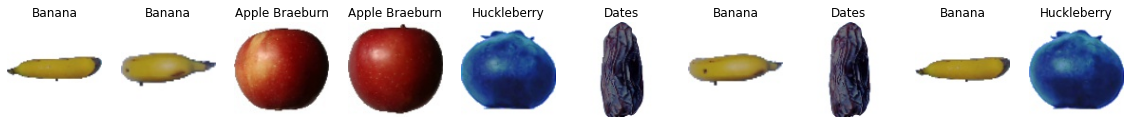

In [0]:
with tf.Session() as sesh:
    sesh.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        for i in range(batches):
            offset = i * epoch
            x = x_train[offset: offset + batch_size]
            y = y_train[offset: offset + batch_size]
            sesh.run(optimizer, feed_dict={X: x, Y:y})
            c = sesh.run(loss, feed_dict={X:x, Y:y})
        # if epoch % 1 == 0 :
        #     print(f'epoch:{epoch} loss={c}')
            
    # Test the model
    
    correct_prediction = tf.equal(tf.argmax(sesh.run(model_output,feed_dict={X: x_test, Y:y_test}),1), tf.argmax(y_test,1))
    accuracy_test = tf.multiply(100.0,tf.reduce_mean(tf.cast(correct_prediction, "float")))
    print('test acc',sesh.run(accuracy_test))

    prediction= tf.argmax(sesh.run(model_output,feed_dict={X: x_test, Y:y_test}),1)

    correct_prediction = tf.equal(tf.argmax(sesh.run(model_output,feed_dict={X: x_train, Y:y_train}),1), tf.argmax(y_train,1))
    accuracy_train = tf.multiply(100.0,tf.reduce_mean(tf.cast(correct_prediction, "float")))
    print('train acc',sesh.run(accuracy_train),'\n')
    
    # show some of test sampel with prediction 
    fig, axes = plt.subplots(1, 10, figsize=(20, 50))
    rand=np.random.randint(600)
    t_imgs=[]
    rand_number=[]
    for i in range(10):
      rand=np.random.randint(600)
      t_imgs.append(x_test[rand])
      rand_number.append(rand)

    for img, ax in zip(t_imgs[0:10], axes):
        guess = np.argmax(sesh.run(model_output, feed_dict={X: [img]}))
        ax.set_title(fruits[guess])
        ax.imshow(img.reshape((100,100,3)))
        ax.axis('off')


# **Confusion Matrix**

In [0]:
from sklearn.metrics import confusion_matrix
with tf.Session() as sesh:
  y_pred=sesh.run(prediction)
  y_pred=pd.get_dummies(y_pred)
  y_pred=np.array(y_pred)

  cm=confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
  cm=pd.DataFrame(cm, index = [i for i in ['Apple', 'Banana', 'Dates', 'Huckleberry']],
                  columns = [i for i in ['Apple', 'Banana', 'Dates', 'Huckleberry']])
  
  print(cm)

             Apple  Banana  Dates  Huckleberry
Apple          136      28      0            0
Banana           0     166      0            0
Dates            0       0    166            0
Huckleberry      0       0     16          150


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


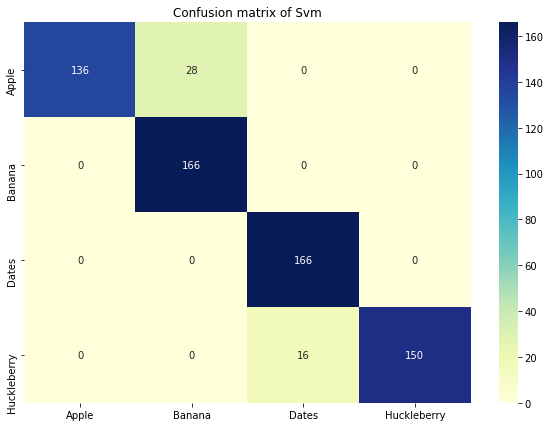

In [0]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
plt.title('Confusion matrix of Svm')
sn.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")
plt.show()